In [1]:
from pyprojroot import here
import sys
sys.path.insert(0, str(here()))

import pandas as pd
import yaml
from laos_gggi import load_emdat_data
import matplotlib.pyplot as plt
from laos_gggi.plotting import configure_plot_style

configure_plot_style()

In [2]:
emdat = load_emdat_data()

In [3]:
with open(here('data/locations.yaml'), 'r') as file:
    locs = yaml.safe_load(file)

In [4]:
loc_dfs = []
for idx, data in locs.items():
    if list(data.keys())[0] != 0:
        data = {0: data}
    temp = pd.DataFrame(data)
    temp.loc['idx'] = idx
    temp = (temp.T
                .reset_index()
                .rename(columns={'index':'location_id', 
                                 'idx':'emdat_index'})
                .set_index(['emdat_index', 'location_id'])
                .assign(lat = lambda x: x.lat.astype(float),
                        long = lambda x: x.long.astype(float)))
    loc_dfs.append(temp)
loc_df = pd.concat(loc_dfs)

In [5]:
cols = ['Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'disaster_class', 'ISO', 'Start_Year', 'Latitude', 'Longitude']
loc_df = pd.merge(pd.concat(loc_dfs).reset_index(),
         emdat['df_raw_filtered'].loc[:, cols].reset_index(), 
         left_on='emdat_index', 
         right_on='index',
         how='outer')

loc_df = (loc_df.assign(emdat_index = lambda x: x.emdat_index.fillna(x['index']),
              location_id = lambda x: x.location_id.fillna(0),
             lat = lambda x: x.lat.fillna(x.Latitude),
             long = lambda x: x.long.fillna(x.Longitude))
     .drop(columns=['index', 'Latitude', 'Longitude'])
     .set_index(['emdat_index', 'location_id']))

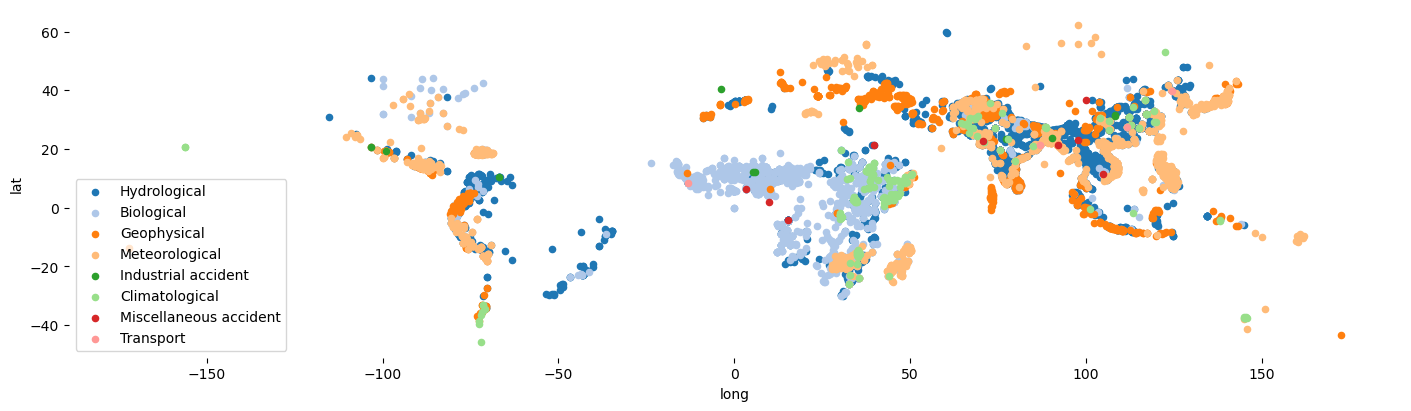

In [6]:
fig, ax = plt.subplots()
for i, group in enumerate(loc_df['Disaster Subgroup'].unique()):
    loc_df.query('`Disaster Subgroup` == @group').plot.scatter(x='long', y='lat', ax=ax, label=group,
                                                          color=plt.color_sequences['tab20'][i])